### Installing the necessary libraries and dependencies

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ze_iy5cc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ze_iy5cc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=833c1af7a7feae2407772b22ae821970303516ea4d0e918aed807fbcab18e3d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-19l4cgfs/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install opendatasets
!pip install pandas
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.1 MB/s eta 0:00:00


In [ ]:
import opendatasets as od
import pandas
od.download('https://www.kaggle.com/datasets/gpiosenka/sports-classification/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shubhpundhir
Your Kaggle Key: ··········


100%|██████████| 424M/424M [00:06<00:00, 66.9MB/s]


In [5]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
import transformers

from PIL import Image
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob

 Preparing a Kaggle dataset for segmentation

In [6]:
class SportsClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*', '*.jpg')))

        # Print the number of loaded images
        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


In [7]:
train_root_dir = os.path.join("/content/sports-classification/train")
valid_root_dir = os.path.join("/content/sports-classification/valid")

# train_transform = pth_transforms.Compose([
#     pth_transforms.Resize((256, 256)),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

train_transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
])

valid_transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SportsClassificationDataset(root_dir=train_root_dir, transform=train_transform)
valid_dataset = SportsClassificationDataset(root_dir=valid_root_dir, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size= 8, shuffle=True, num_workers = 2)

Number of images: 13492
Number of images: 500


## Initializing SAM model:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
sam_checkpoint = '/content/drive/MyDrive/upload/sam_vit_l_0b3195.pth'
model_type = "vit_l" #
device = "cuda" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

(224, 224, 3)


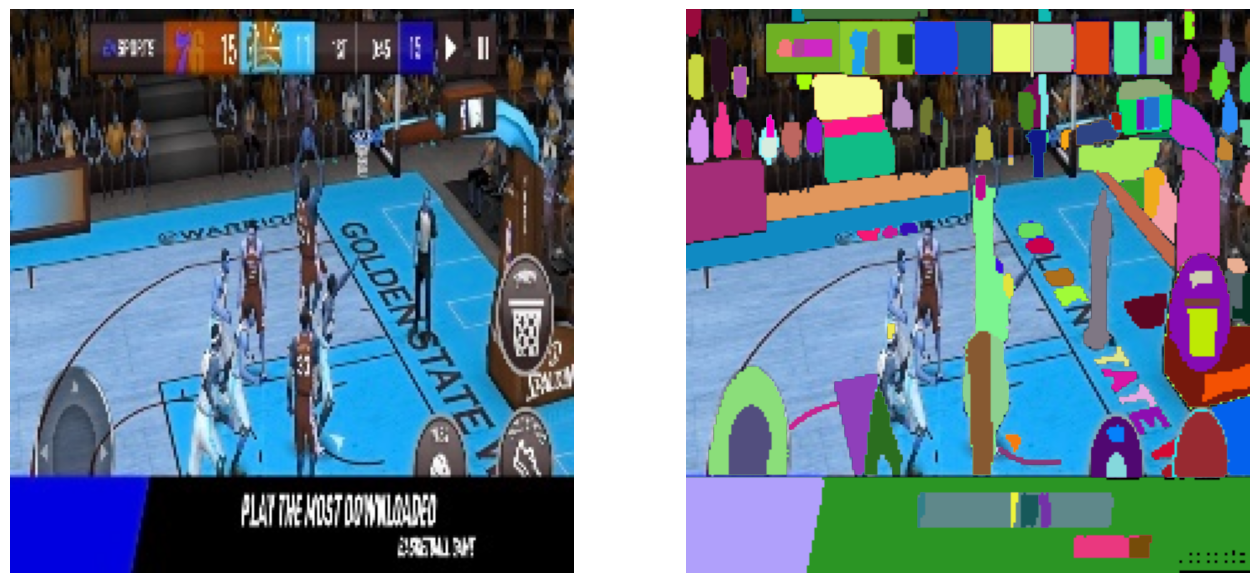

In [10]:
import random

import numpy as np

def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

num_images = 10
random_indices = random.sample(range(len(train_dataset)), num_images)
image_tensor= train_dataset[0]
image_path = "/content/sports-classification/test/basketball/3.jpg"
image_information = cv2.imread(image_path)
image = cv2.resize(image_information, (224,224))
masks = mask_generator1.generate(image)


image_np = image_tensor.numpy()
# Reshape the image data to a valid shape
image_data = np.moveaxis(image_np, 0, -1)  # Move the channels axis to the last position
print(image_data.shape)  # Output: (256, 256, 3)
# Plot the original image and the mask


# Plot the original image and the mask
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
axs[1].imshow(image)
show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()
# for idx in random_indices:
#     # Get the image tensor
#     image_tensor= train_dataset[idx]

#     # Apply the mask generator
#     masks = mask_generator1.generate(image_tensor)

#     # Convert the image tensor back to a PIL image
#     image = torchvision.transforms.ToPILImage()(image_tensor)

#     # Plot the original image and the mask
#     fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#     axs[0].imshow(image)
#     axs[1].imshow(image)
#     show_anns(masks, axs[len(image)][len(image[0])])
#     axs[0].axis('off')
#     axs[1].axis('off')
#     plt.show()